# Hybrid A* 

## First Try

Imports

In [1]:
#!pip install shapely

In [2]:
import numpy as np
import heapq
import math
from matplotlib.path import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon    

Dynamic Function

In [3]:
import numpy as np
from shapely.geometry import Polygon, Point, LineString
import math

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def close_polygon(points):
    """Ensure polygon is closed."""
    if points[0] != points[-1]:
        return points + [points[0]]
    return points


def compute_velocities_from_path(path, max_speed=5.0, dt=0.3):
    """Convert path waypoints to poses with velocities.
    
    Args:
        path: List of (x, y, theta) tuples
        max_speed: Maximum velocity (m/s)
        dt: Time step (seconds)
    
    Returns:
        List of dicts with x, y, theta, v
    """
    poses = []
    for i in range(len(path)):
        x, y, theta = path[i]

        # Compute velocity based on distance to next point
        if i < len(path) - 1:
            nx, ny, _ = path[i+1]
            distance = np.hypot(nx - x, ny - y)
            v = min(distance / dt, max_speed)
        else:
            v = 0.0  # stop at goal

        poses.append({
            "x": x,
            "y": y,
            "theta": theta,
            "v": v
        })

    return poses


def create_track_polygon(track_bounds):
    """Create Shapely polygon from track bounds."""
    if track_bounds[0] != track_bounds[-1]:
        track_bounds = track_bounds + [track_bounds[0]]
    return Polygon(track_bounds)


def is_near_obstacle(x, y, obstacles):
    """Check if position collides with any obstacle."""
    obstacle_safe_radius = CAR_RADIUS + SAFETY_MARGIN
    if not obstacles:
        return False
    for ox, oy in obstacles:
        if np.hypot(ox - x, oy - y) < obstacle_safe_radius:
            return True
    return False


def state_key(x, y, theta):
    """Discretize continuous state to grid key."""
    return (
        round(x / XY_GRID_RESOLUTION),
        round(y / XY_GRID_RESOLUTION),
        round(theta / THETA_GRID_RESOLUTION)
    )


def simulate_motion(x, y, theta, steer):
    """Bicycle model motion simulation."""
    x_new = x + VEHICLE_SPEED * math.cos(theta) * DT
    y_new = y + VEHICLE_SPEED * math.sin(theta) * DT
    theta_new = theta + (VEHICLE_SPEED / WHEELBASE) * math.tan(steer) * DT
    theta_new = (theta_new + 2 * math.pi) % (2 * math.pi)
    return x_new, y_new, theta_new


def generate_neighbors(node):
    """Generate neighboring states from current node."""
    neighbors = []
    for steer in STEERING_ANGLES:
        nx, ny, ntheta = simulate_motion(node.x, node.y, node.theta, steer)
        neighbors.append((nx, ny, ntheta))
    return neighbors


def heuristic(x, y, goal):
    """Distance-to-goal heuristic with weighting."""
    gx, gy = goal
    return HEURISTIC_WEIGHT * np.hypot(gx - x, gy - y)


# ============================================================================
# ADAPTIVE HYPERPARAMETER CLASS
# ============================================================================

class AdaptiveHyperparameters:
    """Dynamically tune Hybrid A* parameters based on map geometry."""
    
    def __init__(self, track_bounds, obstacles=None, vehicle_width=2.0):
        self.track_bounds = track_bounds
        self.obstacles = obstacles if obstacles is not None else []
        self.vehicle_width = vehicle_width
        self.track_poly = create_track_polygon(track_bounds)
        
        # Analyze map and compute parameters
        self._analyze_map()
    
    def _analyze_map(self):
        """Compute map statistics to drive parameter selection."""
        # Track area and bounding box
        self.track_area = self.track_poly.area
        bounds = self.track_poly.bounds  # (minx, miny, maxx, maxy)
        self.min_x, self.min_y, self.max_x, self.max_y = bounds
        self.track_width = self.max_x - self.min_x
        self.track_height = self.max_y - self.min_y
        self.track_diagonal = math.sqrt(self.track_width**2 + self.track_height**2)
        
        # Obstacle density and spacing
        self._compute_obstacle_stats()
        
        # Corridor width analysis
        self._compute_corridor_widths()
    
    def _compute_obstacle_stats(self):
        """Analyze obstacle distribution."""
        if not self.obstacles:
            self.obstacle_count = 0
            self.obstacle_density = 0.0
            self.min_obstacle_distance = float('inf')
            return
        
        self.obstacle_count = len(self.obstacles)
        self.obstacle_density = self.obstacle_count / max(self.track_area, 1.0)
        
        # Minimum distance between obstacles
        min_dist = float('inf')
        for i, (x1, y1) in enumerate(self.obstacles):
            for x2, y2 in self.obstacles[i+1:]:
                dist = math.hypot(x2 - x1, y2 - y1)
                min_dist = min(min_dist, dist)
        
        self.min_obstacle_distance = min_dist if min_dist != float('inf') else self.track_diagonal
    
    def _compute_corridor_widths(self):
        """Sample corridor widths at multiple points along track."""
        # Simple heuristic: distance from centroid to boundary
        centroid = self.track_poly.centroid
        
        # Sample rays in 8 directions
        angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
        distances = []
        
        for angle in angles:
            # Cast ray from centroid
            ray_length = self.track_diagonal
            ray_end_x = centroid.x + ray_length * np.cos(angle)
            ray_end_y = centroid.y + ray_length * np.sin(angle)
            
            # Find intersection with boundary
            ray = LineString([(centroid.x, centroid.y), (ray_end_x, ray_end_y)])
            intersection = self.track_poly.boundary.intersection(ray)
            
            if not intersection.is_empty:
                if hasattr(intersection, 'length'):
                    dist = intersection.length
                else:
                    dist = centroid.distance(intersection)
                distances.append(dist)
        
        self.min_corridor_width = min(distances) * 2 if distances else self.track_width
        self.max_corridor_width = max(distances) * 2 if distances else self.track_width
        self.avg_corridor_width = np.mean(distances) * 2 if distances else self.track_width
    
    def get_xy_resolution(self):
        """Adapt XY grid resolution based on corridor width."""
        base_resolution = self.min_corridor_width * 0.10
        return np.clip(base_resolution, 0.1, 2.0)
    
    def get_theta_resolution(self):
        """Adapt angular resolution based on obstacle density and corridor."""
        base_degrees = 15
        
        if self.obstacle_density > 0.01:
            base_degrees = 10
        if self.obstacle_density > 0.05:
            base_degrees = 7.5
        
        if self.min_corridor_width < 5.0:
            base_degrees = min(base_degrees, 10)
        if self.min_corridor_width < 3.0:
            base_degrees = min(base_degrees, 7.5)
        
        return np.deg2rad(base_degrees)
    
    def get_steering_angles(self):
        """Adapt steering angle range based on corridor width."""
        if self.min_corridor_width < 3.0:
            return [-0.7, -0.5, -0.25, 0, +0.25, +0.5, +0.7]
        elif self.min_corridor_width < 6.0:
            return [-0.6, -0.3, -0.15, 0, +0.15, +0.3, +0.6]
        else:
            return [-0.5, -0.25, 0, +0.25, +0.5]
    
    def get_safety_margin(self):
        """Adapt safety margin based on obstacle density."""
        base_margin = 0.5
        
        if self.obstacle_density > 0.05:
            base_margin = 0.3
        elif self.obstacle_density > 0.01:
            base_margin = 0.4
        
        if self.min_corridor_width < 3.0:
            base_margin = max(base_margin, 0.6)
        
        return base_margin
    
    def get_heuristic_weight(self):
        """Adapt A* heuristic aggressiveness."""
        weight = 1.0
        
        if self.obstacle_density > 0.01:
            weight = 1.1
        if self.obstacle_count > 50:
            weight = 1.15
        
        if self.obstacle_count < 5 and self.min_corridor_width > 10:
            weight = 1.3
        
        return weight
    
    def get_vehicle_speed(self):
        """Adapt speed based on environment complexity."""
        base_speed = 2.5
        
        if self.obstacle_density > 0.05:
            return 1.5
        elif self.obstacle_density > 0.01:
            return 2.0
        elif self.obstacle_count > 30:
            return 2.0
        
        if self.obstacle_count < 5 and self.min_corridor_width > 15:
            return 3.0
        
        return base_speed
    
    def get_wheelbase(self):
        """Usually fixed, but exposed for completeness."""
        return 2.5
    
    def get_dt(self):
        """Adapt time step (smaller → smoother but slower computation)."""
        base_dt = 0.3
        
        if self.min_corridor_width < 3.0:
            return 0.2
        elif self.obstacle_density > 0.02:
            return 0.25
        
        return base_dt
    
    def report(self):
        """Print analysis summary and recommended parameters."""
        print("=" * 60)
        print("ADAPTIVE HYPERPARAMETER ANALYSIS")
        print("=" * 60)
        print(f"\nMap Geometry:")
        print(f"  Track area: {self.track_area:.1f} m²")
        print(f"  Track dimensions: {self.track_width:.1f} × {self.track_height:.1f} m")
        print(f"  Diagonal: {self.track_diagonal:.1f} m")
        print(f"\nCorridor Analysis:")
        print(f"  Min corridor width: {self.min_corridor_width:.2f} m")
        print(f"  Avg corridor width: {self.avg_corridor_width:.2f} m")
        print(f"  Max corridor width: {self.max_corridor_width:.2f} m")
        print(f"\nObstacle Analysis:")
        print(f"  Obstacle count: {self.obstacle_count}")
        print(f"  Obstacle density: {self.obstacle_density:.4f} obs/m²")
        print(f"  Min obstacle distance: {self.min_obstacle_distance:.2f} m")
        print(f"\nRecommended Parameters:")
        print(f"  XY_GRID_RESOLUTION: {self.get_xy_resolution():.3f} m")
        print(f"  THETA_GRID_RESOLUTION: {np.rad2deg(self.get_theta_resolution()):.2f}°")
        print(f"  STEERING_ANGLES: {[f'{a:.2f}' for a in self.get_steering_angles()]}")
        print(f"  SAFETY_MARGIN: {self.get_safety_margin():.2f} m")
        print(f"  VEHICLE_SPEED: {self.get_vehicle_speed():.2f} m/s")
        print(f"  DT: {self.get_dt():.3f} s")
        print(f"  HEURISTIC_WEIGHT: {self.get_heuristic_weight():.2f}")
        print("=" * 60)
    
    def to_dict(self):
        """Export all parameters as dictionary."""
        return {
            'XY_GRID_RESOLUTION': self.get_xy_resolution(),
            'THETA_GRID_RESOLUTION': self.get_theta_resolution(),
            'STEERING_ANGLES': self.get_steering_angles(),
            'SAFETY_MARGIN': self.get_safety_margin(),
            'CAR_RADIUS': self.vehicle_width / 2.0,
            'VEHICLE_SPEED': self.get_vehicle_speed(),
            'WHEELBASE': self.get_wheelbase(),
            'DT': self.get_dt(),
            'HEURISTIC_WEIGHT': self.get_heuristic_weight(),
        }


Hybrid A* Algorithm

In [4]:
import numpy as np
import heapq
import math
from shapely.geometry import Point

class HybridNode:
    def __init__(self, x, y, theta, g, h, parent=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    def __lt__(self, other):
        return self.f < other.f


def compute_transition_cost(x1, y1, theta1, x2, y2, theta2, steer):
    """
    Compute more realistic cost for transition between states.
    
    Includes:
    - Euclidean distance cost
    - Steering angle penalty (penalizes sharp turns)
    - Heading change penalty
    """
    # Distance cost
    distance = np.hypot(x2 - x1, y2 - y1)
    distance_cost = distance
    
    # Steering penalty (prefer straight, penalize sharp turns)
    steering_cost = abs(steer) * 0.5  # weight steering changes
    
    # Heading change penalty (smooth paths preferred)
    theta_diff = abs(theta2 - theta1)
    # Normalize to [0, pi]
    theta_diff = min(theta_diff, 2*np.pi - theta_diff)
    heading_cost = theta_diff * 0.3
    
    total_cost = distance_cost + steering_cost + heading_cost
    return total_cost


def hybrid_astar(start, goal, track_bounds, obstacles=[], max_iterations=50000):
    """
    Hybrid A* pathfinding algorithm with improved cost function.
    
    Args:
        start: (x, y) tuple
        goal: (x, y) tuple
        track_bounds: List of (x, y) vertices defining track polygon
        obstacles: List of (x, y) obstacle positions
        max_iterations: Maximum iterations before timeout
    
    Returns:
        List of (x, y, theta) waypoints, or [] if no path found
    """
    
    # Create Shapely polygon
    track_poly = create_track_polygon(track_bounds)

    start_x, start_y = start
    goal_x, goal_y = goal

    start_node = HybridNode(
        x=start_x,
        y=start_y,
        theta=0.0,
        g=0.0,
        h=heuristic(start_x, start_y, goal),
        parent=None
    )

    open_list = []
    heapq.heappush(open_list, start_node)

    closed = set()  # discretized visited states
    iterations = 0

    while open_list and iterations < max_iterations:
        iterations += 1
        current = heapq.heappop(open_list)

        # Check if goal reached (tighter tolerance for better paths)
        goal_distance = np.hypot(current.x - goal_x, current.y - goal_y)
        if goal_distance < 0.5:  # 0.5m tolerance
            path = []
            node = current
            while node:
                path.append((node.x, node.y, node.theta))
                node = node.parent
            return path[::-1]

        closed_key = state_key(current.x, current.y, current.theta)
        if closed_key in closed:
            continue
        closed.add(closed_key)

        # Expand neighbors with all steering angles
        for steer_idx, steer in enumerate(STEERING_ANGLES):
            nx, ny, ntheta = simulate_motion(current.x, current.y, current.theta, steer)

            # 1. Track boundary collision via Shapely
            if not track_poly.contains(Point(nx, ny)):
                continue

            # 2. Obstacle collision
            if obstacles and is_near_obstacle(nx, ny, obstacles):
                continue

            neighbor_key = state_key(nx, ny, ntheta)
            if neighbor_key in closed:
                continue

            # Use improved cost function
            transition_cost = compute_transition_cost(
                current.x, current.y, current.theta,
                nx, ny, ntheta,
                steer
            )
            g_new = current.g + transition_cost
            h_new = heuristic(nx, ny, goal)

            new_node = HybridNode(
                x=nx,
                y=ny,
                theta=ntheta,
                g=g_new,
                h=h_new,
                parent=current
            )

            heapq.heappush(open_list, new_node)

    # Timeout or no solution
    if iterations >= max_iterations:
        print(f"[WARNING] Hybrid A* reached max iterations ({max_iterations})")
    return []


Visualization Function

In [5]:
def visualize_path(track_bounds, car_location, goal, path, obstacles=None, title=""):
    plt.figure(figsize=(8, 6))
    plt.title(title)

    # Draw track boundaries
    tb = close_polygon(track_bounds)
    bx, by = zip(*tb)
    plt.plot(bx, by, 'b-', linewidth=2, label="Track Boundary")

    # Draw Start & Goal
    plt.plot(car_location[0], car_location[1], 'go', markersize=8, label="Start")
    plt.plot(goal[0], goal[1], 'ro', markersize=8, label="Goal")

    # Draw Obstacles
    if obstacles and len(obstacles) > 0:
        ox = [o[0] for o in obstacles]
        oy = [o[1] for o in obstacles]
        plt.scatter(ox, oy, c='red', s=30, label="Obstacles", alpha=0.7)

    # Draw Path
    if path and len(path) > 1:
        px = [p[0] for p in path]
        py = [p[1] for p in path]
        plt.plot(px, py, 'yellow', linewidth=2, label="Hybrid A* Path")
    else:
        plt.text(0.5, 0.5, "NO PATH FOUND", fontsize=16, color="red", transform=plt.gca().transAxes)

    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()


Test Cases

In [6]:
import numpy as np

test_cases = [

    # 1. Simple Rectangle (baseline sanity check)
    {
        "name": "Simple Rectangle",
        "track_bounds": [(0,0), (100,0), (100,60), (0,60)],
        "car_location": (10,10),
        "goal": (90,50),
        "obstacles": []
    },

    # 2. L-Shape Track
    {
        "name": "L-Shape Track",
        "track_bounds": [(0,0), (80,0), (80,20), (30,20), (30,60), (0,60)],
        "car_location": (5,5),
        "goal": (70,15),
        "obstacles": []
    },

    # 3. Narrow Corridor (tests turning radius / corridor navigation)
    {
        "name": "Narrow Corridor",
        "track_bounds": [(0,0), (100,0), (100,20), (0,20)],
        "car_location": (10,10),
        "goal": (90,10),
        "obstacles": []
    },

    # 4. Complex Multi-Turn Polygon Track (wider “road” but irregular shape)
    {
        "name": "Complex Polygon Track",
        "track_bounds": [(10,10), (90,10), (100,40), (80,80),
                         (50,90), (20,70), (5,50)],
        "car_location": (20,20),
        "goal": (85,30),
        "obstacles": []
    },

    # 5. Obstacle-Heavy Field inside Rectangular Bounds (dense random obstacles)
    {
        "name": "Dense Random Obstacle Field",
        "track_bounds": [(0,0), (150,0), (150,150), (0,150)],
        "car_location": (20,20),
        "goal": (130,130),
        "obstacles": [
            (75 + np.random.randn()*18, 75 + np.random.randn()*18)
            for _ in range(120)
        ]
    },

    # 6. Bottleneck + Mixed-width Track With Random Obstacles near Bottleneck
    {
        "name": "Bottleneck with Obstacles",
        "track_bounds": [
            (0,0), (120,0), (120,40), (80,40),
            (80,20), (40,20), (40,40), (0,40)
        ],
        "car_location": (10,10),
        "goal": (110,30),
        "obstacles": [
            # cluster near the bottleneck to force planning around it
            (60 + np.random.randn()*3, 18 + np.random.randn()*2)
            for _ in range(15)
        ]
    },

    # 7. Sinusoidal / Curvy “Road” with Chicanes + Obstacles
    {
        "name": "Wavy Chicane Road",
        # track defined as a wide bounding polygon approximating a road
        "track_bounds": [
            (0,0), (120,0), (120,20),
            (100,40), (120,60), (120,80),
            (0,80), (0,60), (20,40), (0,20)
        ],
        "car_location": (5,5),
        "goal": (115,75),
        "obstacles": [
            # place obstacles (like cones/barrels) at various strategic locations
            (30 + np.random.randn()*2, 25 + np.random.randn()*2),
            (60 + np.random.randn()*2, 35 + np.random.randn()*2),
            (90 + np.random.randn()*2, 55 + np.random.randn()*2),
            (50 + np.random.randn()*2, 70 + np.random.randn()*2),
            (20 + np.random.randn()*2, 50 + np.random.randn()*2),
        ]
    },

    # 8. Maze-like Track (multiple dead-ends, narrow corridors)
    {
        "name": "Maze Track",
        "track_bounds": [
            (0,0), (140,0), (140,140), (100,140), (100,100),
            (120,100), (120,40), (20,40), (20,100), (40,100),
            (40,140), (0,140)
        ],
        "car_location": (10,10),
        "goal": (130,130),
        "obstacles": []
    },

    # 9. Typical Autonomous-Competition Track: Lane-like Boundaries + Random Cones/Barrels
    {
        "name": "Competition-Style Lane Track",
        # imagine a winding track within these bounds
        "track_bounds": [
            (0,0), (200,0), (200,120), (180,140),
            (160,120), (140,140), (120,120), (100,140),
            (80,120), (60,140), (40,120), (0,120)
        ],
        "car_location": (10,10),
        "goal": (180,110),
        "obstacles": [
            # random obstacles like barrels/cones — spacing ensures a minimum clearance around them
            (50, 60), (70, 70), (100, 80), (120, 90),
            (130, 100), (160, 110), (90, 50), (110, 30),
            (60, 20), (140, 40)
        ]
    },

    # 10. Track with “Choke + Wide → Narrow → Wide” Segments + Sparse Obstacles
    {
        "name": "Variable-width Track with Sparse Obstacles",
        "track_bounds": [
            (0,0), (250,0), (250,150), (200,150),
            (200,100), (150,100), (150,150), (0,150)
        ],
        "car_location": (10,10),
        "goal": (240,140),
        "obstacles": [
            (50 + np.random.randn()*5, 20 + np.random.randn()*5),
            (120 + np.random.randn()*5, 80 + np.random.randn()*5),
            (180 + np.random.randn()*5, 130 + np.random.randn()*5),
        ]
    }
]


Diagonisis in case of no path found

In [7]:
import numpy as np
from shapely.geometry import Point, LineString

def diagnose_pathfinding_failure(start, goal, track_bounds, obstacles, adaptive_config):
    """
    Diagnose why pathfinding failed for a given test case.
    
    Checks:
    1. Start/goal within track boundaries
    2. Start/goal far enough from obstacles
    3. Whether a straight line exists between start and goal
    4. Track geometry validity
    5. Parameter reasonableness
    """
    
    print("\n" + "="*70)
    print("PATHFINDING FAILURE DIAGNOSIS")
    print("="*70)
    
    track_poly = create_track_polygon(track_bounds)
    start_point = Point(start)
    goal_point = Point(goal)
    
    # Check 1: Start position
    print("\n[CHECK 1] Start Position")
    if track_poly.contains(start_point):
        print(f"  ✓ Start {start} is inside track")
    else:
        print(f"  ✗ START {start} IS OUTSIDE TRACK - FIX IMMEDIATELY")
        return False
    
    start_dist_to_obs = min(
        [np.hypot(start[0] - ox, start[1] - oy) for ox, oy in obstacles],
        default=float('inf')
    )
    obstacle_radius = adaptive_config['CAR_RADIUS'] + adaptive_config['SAFETY_MARGIN']
    if start_dist_to_obs > obstacle_radius:
        print(f"  ✓ Start is {start_dist_to_obs:.2f}m from nearest obstacle (safe radius: {obstacle_radius:.2f}m)")
    else:
        print(f"  ✗ START TOO CLOSE TO OBSTACLE: {start_dist_to_obs:.2f}m vs {obstacle_radius:.2f}m")
        return False
    
    # Check 2: Goal position
    print("\n[CHECK 2] Goal Position")
    if track_poly.contains(goal_point):
        print(f"  ✓ Goal {goal} is inside track")
    else:
        print(f"  ✗ GOAL {goal} IS OUTSIDE TRACK - FIX IMMEDIATELY")
        return False
    
    goal_dist_to_obs = min(
        [np.hypot(goal[0] - ox, goal[1] - oy) for ox, oy in obstacles],
        default=float('inf')
    )
    if goal_dist_to_obs > obstacle_radius:
        print(f"  ✓ Goal is {goal_dist_to_obs:.2f}m from nearest obstacle (safe radius: {obstacle_radius:.2f}m)")
    else:
        print(f"  ✗ GOAL TOO CLOSE TO OBSTACLE: {goal_dist_to_obs:.2f}m vs {obstacle_radius:.2f}m")
        return False
    
    # Check 3: Straight-line path feasibility
    print("\n[CHECK 3] Straight-line Path (sanity check)")
    straight_line = LineString([start, goal])
    if track_poly.contains(straight_line):
        print(f"  ✓ Straight line from start to goal is clear")
    else:
        print(f"  ✗ Straight line path blocked or touches boundary")
        print(f"     → This suggests a path may still exist but requires planning")
    
    # Check 4: Track geometry
    print("\n[CHECK 4] Track Geometry")
    print(f"  Track area: {track_poly.area:.1f} m²")
    print(f"  Track bounds: {track_poly.bounds}")
    print(f"  Track is valid polygon: {track_poly.is_valid}")
    
    if not track_poly.is_valid:
        print(f"  ✗ INVALID TRACK POLYGON - may cause issues")
        return False
    
    # Check 5: Adaptive parameters
    print("\n[CHECK 5] Adaptive Parameters")
    print(f"  XY Grid Resolution: {adaptive_config['XY_GRID_RESOLUTION']:.3f} m")
    print(f"  Theta Grid Resolution: {np.rad2deg(adaptive_config['THETA_GRID_RESOLUTION']):.2f}°")
    print(f"  Steering angles: {len(adaptive_config['STEERING_ANGLES'])} samples")
    print(f"  Safety margin: {adaptive_config['SAFETY_MARGIN']:.2f} m")
    print(f"  Vehicle speed: {adaptive_config['VEHICLE_SPEED']:.2f} m/s")
    print(f"  Time step: {adaptive_config['DT']:.3f} s")
    print(f"  Heuristic weight: {adaptive_config['HEURISTIC_WEIGHT']:.2f}")
    
    # Check for unreasonable parameters
    if adaptive_config['XY_GRID_RESOLUTION'] > 5.0:
        print(f"  ⚠ WARNING: Grid resolution very coarse ({adaptive_config['XY_GRID_RESOLUTION']:.2f}m)")
    
    # Check 6: Obstacle density
    print("\n[CHECK 6] Obstacle Analysis")
    obstacle_count = len(obstacles)
    print(f"  Obstacle count: {obstacle_count}")
    
    if obstacle_count > 0:
        min_dist = min(
            [np.hypot(obstacles[i][0] - obstacles[j][0], 
                     obstacles[i][1] - obstacles[j][1])
             for i in range(len(obstacles))
             for j in range(i+1, len(obstacles))],
            default=float('inf')
        )
        print(f"  Min distance between obstacles: {min_dist:.2f} m")
        print(f"  Safe passage width needed: {2 * obstacle_radius:.2f} m")
        
        if min_dist < 2 * obstacle_radius:
            print(f"  ⚠ WARNING: Some obstacles may be too close together")
    
    return True


def suggest_fixes(case_name, adaptive):
    """Suggest parameter adjustments for failing cases."""
    
    print("\n" + "="*70)
    print("SUGGESTED FIXES")
    print("="*70)
    
    suggestions = []
    
    # If corridor is tight
    if adaptive.min_corridor_width < 3.0:
        suggestions.append("Narrow corridor detected:")
        suggestions.append(f"  • Try reducing SAFETY_MARGIN from {adaptive.get_safety_margin():.2f} to 0.3 m")
        suggestions.append(f"  • Current min corridor: {adaptive.min_corridor_width:.2f} m")
        suggestions.append(f"  • Vehicle needs at least {2 * (adaptive.get_safety_margin() + 1.0):.2f} m clearance")
    
    # If high obstacle density
    if adaptive.obstacle_density > 0.02:
        suggestions.append("High obstacle density detected:")
        suggestions.append(f"  • Try reducing grid resolution further")
        suggestions.append(f"  • Increase max_iterations in hybrid_astar()")
        suggestions.append(f"  • Reduce STEERING_ANGLES to search faster")
    
    # If large track
    if adaptive.track_diagonal > 200:
        suggestions.append("Large track detected:")
        suggestions.append(f"  • Increase max_iterations (currently 50000)")
        suggestions.append(f"  • Coarser grid may help: XY_GRID_RESOLUTION > 1.0 m")
    
    if not suggestions:
        suggestions.append("No obvious issues detected. Try:")
        suggestions.append("  • Increase max_iterations in hybrid_astar()")
        suggestions.append("  • Reduce SAFETY_MARGIN")
        suggestions.append("  • Verify start/goal are reachable manually")
    
    for suggestion in suggestions:
        print(f"  {suggestion}")

Testing


--- Running Test Case: Simple Rectangle ---
Path found: Yes
Path length (number of waypoints): 180
Pose array length: 180
Compute time: 1.879s
First 3 poses: [{'x': 10, 'y': 10, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 10.5, 'y': 10.0, 'theta': 0.1092604979687577, 'v': np.float64(1.666666666666666)}, {'x': 10.997018503723366, 'y': 10.054521619166954, 'theta': 0.2185209959375154, 'v': np.float64(1.6666666666666683)}]


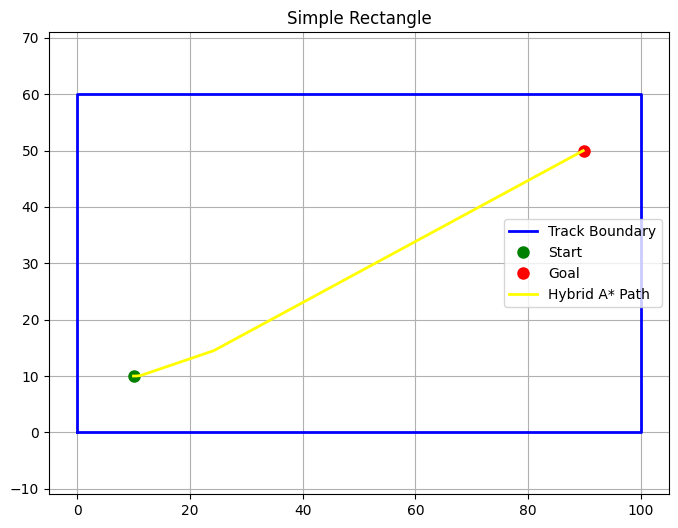


--- Running Test Case: L-Shape Track ---
Path found: Yes
Path length (number of waypoints): 132
Pose array length: 132
Compute time: 1.332s
First 3 poses: [{'x': 5, 'y': 5, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 5.5, 'y': 5.0, 'theta': 0.1092604979687577, 'v': np.float64(1.6666666666666656)}, {'x': 5.997018503723366, 'y': 5.054521619166953, 'theta': 0.1092604979687577, 'v': np.float64(1.6666666666666656)}]


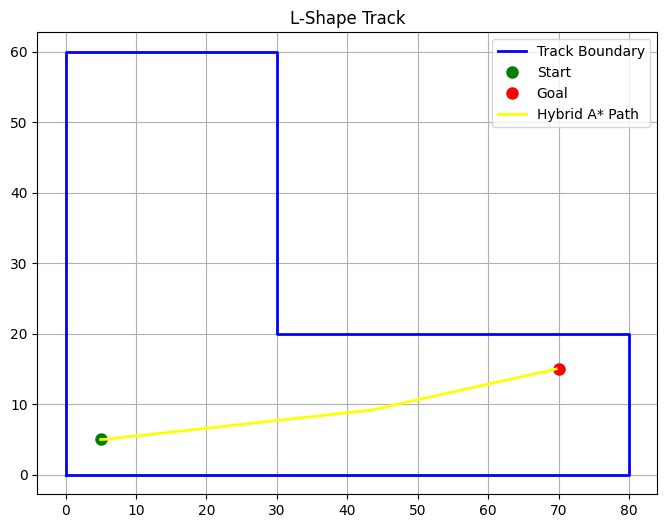


--- Running Test Case: Narrow Corridor ---
Path found: Yes
Path length (number of waypoints): 161
Pose array length: 161
Compute time: 0.035s
First 3 poses: [{'x': 10, 'y': 10, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 10.5, 'y': 10.0, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 11.0, 'y': 10.0, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}]


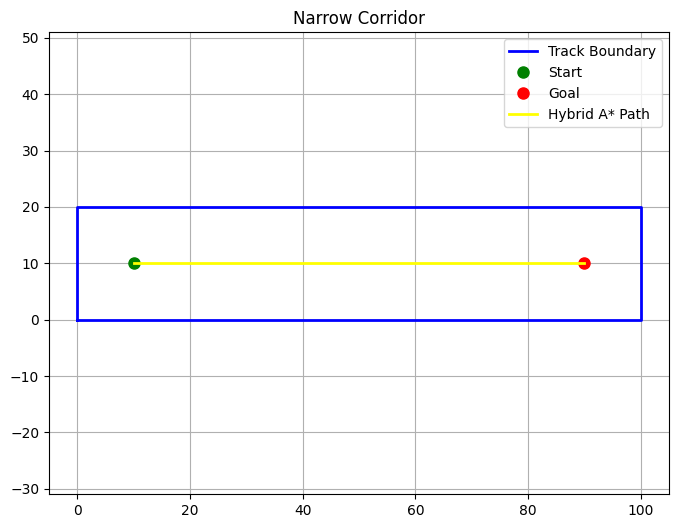


--- Running Test Case: Complex Polygon Track ---
Path found: Yes
Path length (number of waypoints): 132
Pose array length: 132
Compute time: 1.360s
First 3 poses: [{'x': 20, 'y': 20, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 20.5, 'y': 20.0, 'theta': 0.1092604979687577, 'v': np.float64(1.6666666666666712)}, {'x': 20.997018503723368, 'y': 20.05452161916695, 'theta': 0.1092604979687577, 'v': np.float64(1.6666666666666712)}]


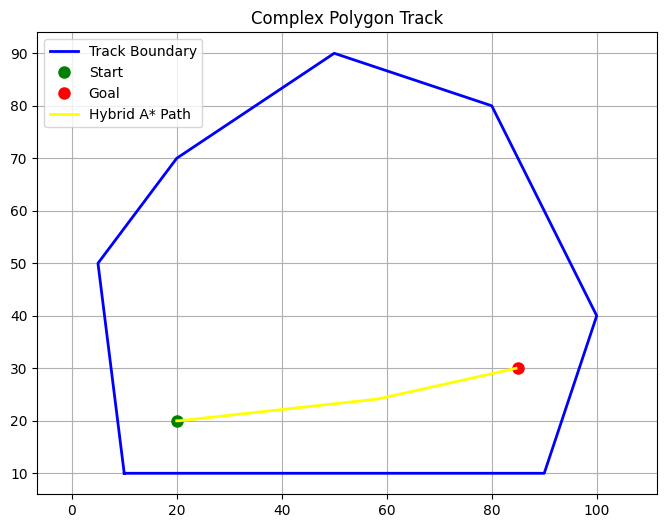


--- Running Test Case: Dense Random Obstacle Field ---
Path found: Yes
Path length (number of waypoints): 403
Pose array length: 403
Compute time: 23.653s
First 3 poses: [{'x': 20, 'y': 20, 'theta': 0.0, 'v': np.float64(1.3333333333333286)}, {'x': 20.4, 'y': 20.0, 'theta': 0.08740839837500669, 'v': np.float64(1.3333333333333373)}, {'x': 20.798472927015727, 'y': 20.034918855014435, 'theta': 0.22217453924909947, 'v': np.float64(1.3333333333333328)}]


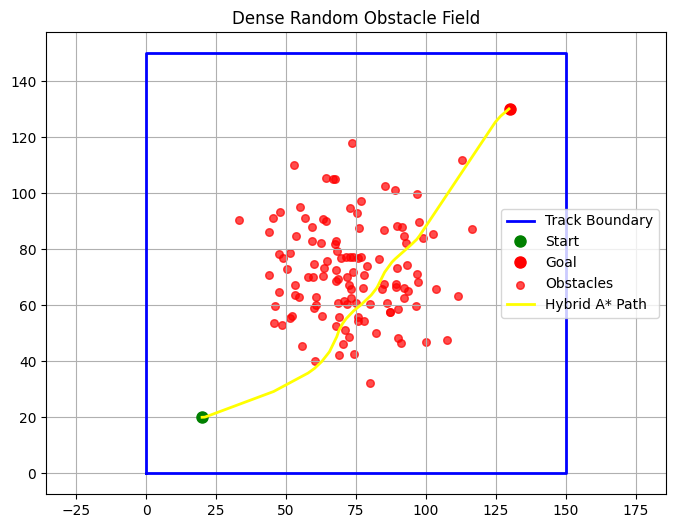


--- Running Test Case: Bottleneck with Obstacles ---
[WARNING] Hybrid A* reached max iterations (50000)

PATHFINDING FAILURE DIAGNOSIS

[CHECK 1] Start Position
  ✓ Start (10, 10) is inside track
  ✓ Start is 46.66m from nearest obstacle (safe radius: 1.60m)

[CHECK 2] Goal Position
  ✓ Goal (110, 30) is inside track
  ✓ Goal is 49.22m from nearest obstacle (safe radius: 1.60m)

[CHECK 3] Straight-line Path (sanity check)
  ✗ Straight line path blocked or touches boundary
     → This suggests a path may still exist but requires planning

[CHECK 4] Track Geometry
  Track area: 4000.0 m²
  Track bounds: (0.0, 0.0, 120.0, 40.0)
  Track is valid polygon: True

[CHECK 5] Adaptive Parameters
  XY Grid Resolution: 0.100 m
  Theta Grid Resolution: 7.50°
  Steering angles: 7 samples
  Safety margin: 0.60 m
  Vehicle speed: 2.50 m/s
  Time step: 0.200 s
  Heuristic weight: 1.00

[CHECK 6] Obstacle Analysis
  Obstacle count: 15
  Min distance between obstacles: 0.22 m
  Safe passage width needed

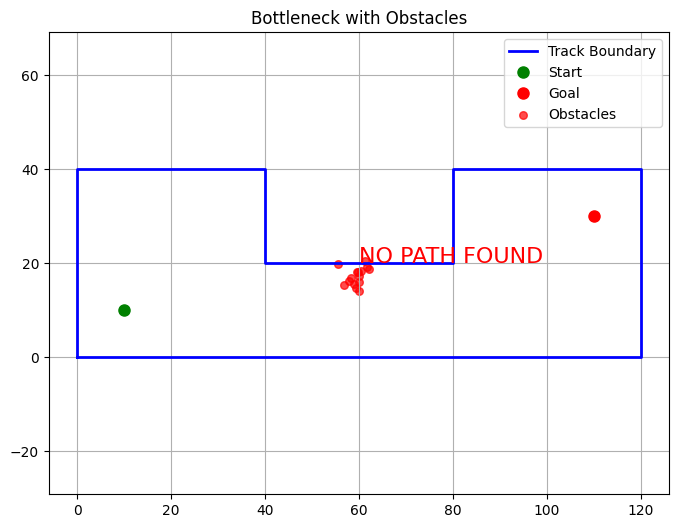


--- Running Test Case: Wavy Chicane Road ---
Path found: Yes
Path length (number of waypoints): 262
Pose array length: 262
Compute time: 4.369s
First 3 poses: [{'x': 5, 'y': 5, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 5.5, 'y': 5.0, 'theta': 0.1092604979687577, 'v': np.float64(1.6666666666666656)}, {'x': 5.997018503723366, 'y': 5.054521619166953, 'theta': 0.2185209959375154, 'v': np.float64(1.666666666666666)}]


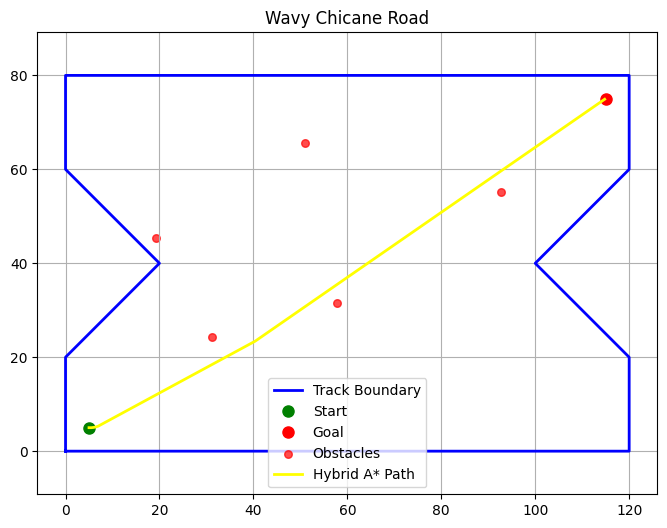


--- Running Test Case: Maze Track ---
[WARNING] Hybrid A* reached max iterations (50000)

PATHFINDING FAILURE DIAGNOSIS

[CHECK 1] Start Position
  ✓ Start (10, 10) is inside track
  ✓ Start is infm from nearest obstacle (safe radius: 1.60m)

[CHECK 2] Goal Position
  ✓ Goal (130, 130) is inside track
  ✓ Goal is infm from nearest obstacle (safe radius: 1.60m)

[CHECK 3] Straight-line Path (sanity check)
  ✗ Straight line path blocked or touches boundary
     → This suggests a path may still exist but requires planning

[CHECK 4] Track Geometry
  Track area: 11200.0 m²
  Track bounds: (0.0, 0.0, 140.0, 140.0)
  Track is valid polygon: True

[CHECK 5] Adaptive Parameters
  XY Grid Resolution: 0.100 m
  Theta Grid Resolution: 7.50°
  Steering angles: 7 samples
  Safety margin: 0.60 m
  Vehicle speed: 2.50 m/s
  Time step: 0.200 s
  Heuristic weight: 1.00

[CHECK 6] Obstacle Analysis
  Obstacle count: 0

SUGGESTED FIXES
  Narrow corridor detected:
    • Try reducing SAFETY_MARGIN from 0.

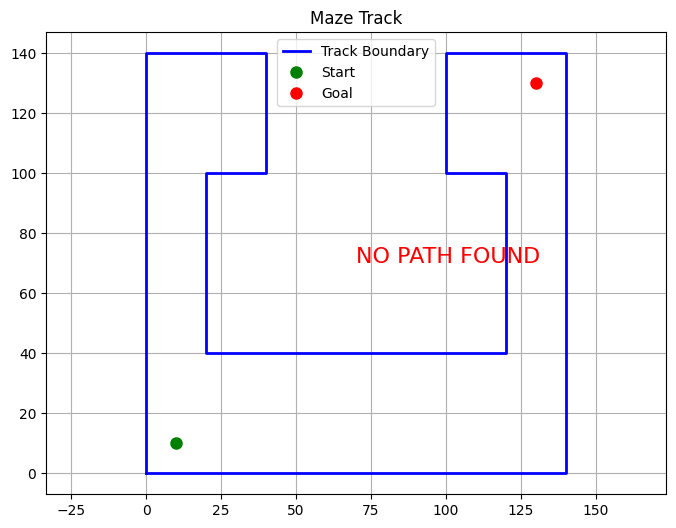


--- Running Test Case: Competition-Style Lane Track ---
Path found: Yes
Path length (number of waypoints): 395
Pose array length: 395
Compute time: 15.758s
First 3 poses: [{'x': 10, 'y': 10, 'theta': 0.0, 'v': np.float64(1.6666666666666667)}, {'x': 10.5, 'y': 10.0, 'theta': 0.1092604979687577, 'v': np.float64(1.666666666666666)}, {'x': 10.997018503723366, 'y': 10.054521619166954, 'theta': 0.2185209959375154, 'v': np.float64(1.6666666666666683)}]


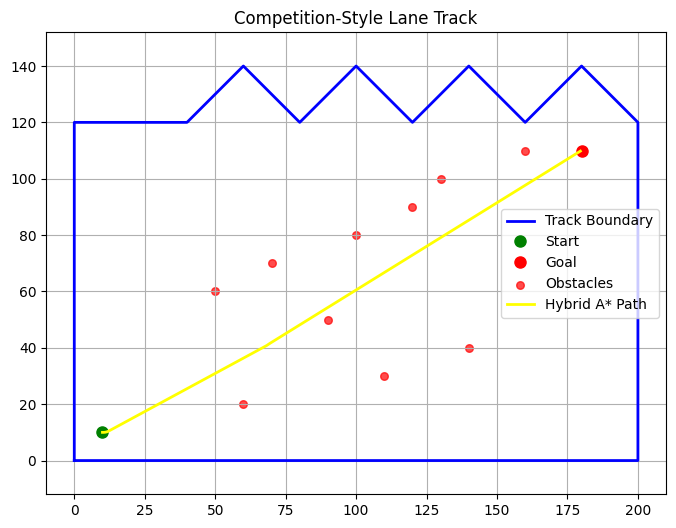


--- Running Test Case: Variable-width Track with Sparse Obstacles ---
[WARNING] Hybrid A* reached max iterations (50000)

PATHFINDING FAILURE DIAGNOSIS

[CHECK 1] Start Position
  ✓ Start (10, 10) is inside track
  ✓ Start is 44.94m from nearest obstacle (safe radius: 1.60m)

[CHECK 2] Goal Position
  ✓ Goal (240, 140) is inside track
  ✓ Goal is 63.59m from nearest obstacle (safe radius: 1.60m)

[CHECK 3] Straight-line Path (sanity check)
  ✗ Straight line path blocked or touches boundary
     → This suggests a path may still exist but requires planning

[CHECK 4] Track Geometry
  Track area: 35000.0 m²
  Track bounds: (0.0, 0.0, 250.0, 150.0)
  Track is valid polygon: True

[CHECK 5] Adaptive Parameters
  XY Grid Resolution: 0.100 m
  Theta Grid Resolution: 7.50°
  Steering angles: 7 samples
  Safety margin: 0.60 m
  Vehicle speed: 2.50 m/s
  Time step: 0.200 s
  Heuristic weight: 1.00

[CHECK 6] Obstacle Analysis
  Obstacle count: 3
  Min distance between obstacles: 71.70 m
  Safe 

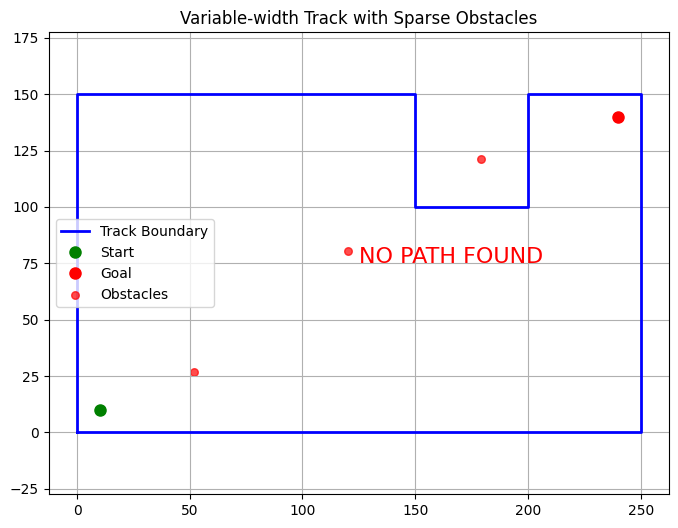


All test cases finished.

                                         name  success  path_length  \
0                            Simple Rectangle     True          180   
1                               L-Shape Track     True          132   
2                             Narrow Corridor     True          161   
3                       Complex Polygon Track     True          132   
4                 Dense Random Obstacle Field     True          403   
5                   Bottleneck with Obstacles    False            0   
6                           Wavy Chicane Road     True          262   
7                                  Maze Track    False            0   
8                Competition-Style Lane Track     True          395   
9  Variable-width Track with Sparse Obstacles    False            0   

   compute_time  num_obstacles  min_corridor_width  
0      1.878612              0                 0.0  
1      1.331952              0                 0.0  
2      0.034816              0  

In [8]:
import numpy as np
import pandas as pd
import time

# Seed for reproducibility
np.random.seed(42)

results = []

for case in test_cases:
    print(f"\n--- Running Test Case: {case['name']} ---")

    track = case["track_bounds"]
    car = case["car_location"]
    goal = case["goal"]
    obstacles = case["obstacles"]

    # Get adaptive hyperparameters
    adaptive = AdaptiveHyperparameters(track, obstacles, vehicle_width=2.0)
    config = adaptive.to_dict()
    
    # Set global parameters from adaptive config
    XY_GRID_RESOLUTION = config['XY_GRID_RESOLUTION']
    THETA_GRID_RESOLUTION = config['THETA_GRID_RESOLUTION']
    STEERING_ANGLES = config['STEERING_ANGLES']
    SAFETY_MARGIN = config['SAFETY_MARGIN']
    CAR_RADIUS = config['CAR_RADIUS']
    VEHICLE_SPEED = config['VEHICLE_SPEED']
    WHEELBASE = config['WHEELBASE']
    DT = config['DT']
    HEURISTIC_WEIGHT = config['HEURISTIC_WEIGHT']

    # Run Hybrid A*
    start_time = time.time()
    raw_path = hybrid_astar(car, goal, track, obstacles)
    elapsed_time = time.time() - start_time
    
    # If pathfinding failed
    if not raw_path:  
        diagnose_pathfinding_failure(car, goal, track, obstacles, config)
        suggest_fixes(case["name"], adaptive)

    # Convert raw Hybrid A* path to array of poses
    pose_array = compute_velocities_from_path(raw_path)

    # Store results
    results.append({
        "name": case["name"],
        "pose_array": pose_array,
        "path_length": len(raw_path),
        "success": len(raw_path) > 0,
        "compute_time": elapsed_time,
        "num_obstacles": len(obstacles),
        "min_corridor_width": adaptive.min_corridor_width
    })

    print(f"Path found: {'Yes' if len(raw_path) > 0 else 'No'}")
    print(f"Path length (number of waypoints): {len(raw_path)}")    
    print(f"Pose array length: {len(pose_array)}")
    print(f"Compute time: {elapsed_time:.3f}s")
    if pose_array:
        print(f"First 3 poses: {pose_array[:3]}")

    # Visualize
    visualize_path(
        track_bounds=track,
        car_location=car,
        goal=goal,
        path=raw_path,
        obstacles=obstacles,
        title=case["name"]
    )

print("\nAll test cases finished.\n")

# Show summary
df_results = pd.DataFrame(results)
print(df_results[['name', 'success', 'path_length', 'compute_time', 'num_obstacles', 'min_corridor_width']])

1. path calculation
2. no path found (track boundaries)
3. lattice planner & local planner
